## Pipeline
- **Creating the Pipeline:**
  - `Pipeline` is used to streamline and chain multiple steps of data processing and modeling into a single workflow.

In [180]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Generating a random dataset with 10 rows and 4 columns
np.random.seed(42)  # For reproducibility
data = np.random.randn(10, 4)

# Creating a DataFrame and naming the columns
df = pd.DataFrame(data, columns=['f1', 'f2', 'f3', 'y'])

df

,f1,f2,f3,y
0,0.496714,-0.138264,0.647689,1.523030
1,-0.234153,-0.234137,1.579213,0.767435
2,-0.469474,0.542560,-0.463418,-0.465730
3,0.241962,-1.913280,-1.724918,-0.562288
4,-1.012831,0.314247,-0.908024,-1.412304
5,1.465649,-0.225776,0.067528,-1.424748
6,-0.544383,0.110923,-1.150994,0.375698
7,-0.600639,-0.291694,-0.601707,1.852278
8,-0.013497,-1.057711,0.822545,-1.220844
9,0.208864,-1.959670,-1.328186,0.196861


- **Pipeline Definition:**
  - **`Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])`:**
    - **Name:** `Pipeline`
    - **Steps:**
      - **`('scaler', StandardScaler())`:**
        - **Name:** `scaler`
        - **Transformation:** `StandardScaler()`
        - **Purpose:** Standardizes features by removing the mean and scaling to unit variance.
      
      - **`('pca', PCA(n_components=2))`:**
        - **Name:** `pca`
        - **Transformation:** `PCA(n_components=2)`
        - **Purpose:** Reduces the dimensionality of the data to 2 principal components.

- **Transforming the Data:**
  - `fit_transform(df)`: Applies the transformations defined in the pipeline to the DataFrame.
  - `pd.DataFrame(...)`: Creates a new DataFrame with transformed data and appropriate column names.

In [181]:
# Define Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply StandardScaler
    ('pca', PCA(n_components=2))
])

In [182]:
# pipeline.fit_transform(df)

In [183]:
pd.DataFrame(pipeline.fit_transform(df), columns=pipeline.get_feature_names_out())

,pca0,pca1
0,0.781136,1.284516
1,1.326924,1.253573
2,0.946829,-0.465876
3,-2.092944,-0.884453
4,0.667365,-1.355849
5,-1.262295,1.770551
6,0.690187,-1.078296
7,1.125083,-0.737482
8,-0.489777,0.829789
9,-1.692507,-0.616474


## **Example: Using ColumnTransformer, FeatureUnion, and Pipeline**


In [184]:
df = pd.read_csv(r"../data/sentimentdataset.csv")

In [185]:
df.head()

,Review,Platform,Sentiment
0,Enjoying a beautiful day at the park! ...,Twitter,1
1,Traffic was terrible this morning. ...,Twitter,0
2,Just finished an amazing workout! 💪 ...,Instagram,1
3,Excited about the upcoming weekend getaway! ...,Facebook,1
4,Trying out a new recipe for dinner tonight. ...,Instagram,1


- **Creating a Custom Transformer (function transformer a stateless transformer):**
    - **Purpose:** Count the number of words in each review.
    - **Function:** `count_words`


In [186]:
def count_words(X):
    # Count the number of words in each review
    # Assuming reviews is a 1D array-like of text strings
    return np.array([len(Review.split()) for Review in X]).reshape(-1, 1)

In [187]:
from sklearn.preprocessing import FunctionTransformer

# Create the FunctionTransformer using the count_words function
word_count_transformer = FunctionTransformer(count_words)

  - **FeatureUnion:**
    - **Purpose:** Combine multiple feature extraction methods.
    - **Components:**
      - **`word_count_transformer`**: Counts words in reviews.
      - **`CountVectorizer`**: Converts text to a bag-of-words matrix.

In [188]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer


feature_union = FeatureUnion([
    ('word_count', word_count_transformer),
    ('bag_of_words', CountVectorizer())
])

  - **ColumnTransformer:**
    - **Purpose:** Apply different preprocessing steps to different columns.
    - **Components:**
      - **`OneHotEncoder`**: Applies one-hot encoding to the `Platform` column.
      - **`feature_union`**: Applies `word_count_transformer` and `CountVectorizer` to the `Review` column.

In [189]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer(
    transformers=[
        ('platform_ohe', OneHotEncoder(), ['Platform']),
        ('review_processing', feature_union, 'Review')
    ],
    remainder='drop'  # Drop other columns not specified here
)

  - **Pipeline:**
    - **Purpose:** Chain multiple steps including data transformation and model fitting.
    - **Steps:**
      - **`col_transformer`**: Applies column transformations.
      - **`MaxAbsScaler`**: Scales features by their maximum absolute value.
      - **`SelectKBest`**: Selects the top 10 features based on chi-square test.
      - **`LogisticRegression`**: Classifies data using logistic regression.

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline


final_pipeline = Pipeline(steps=[
    ('col_transformer', column_transformer),
    ('scaler', MaxAbsScaler()),
    ('selector', SelectKBest(score_func=chi2,k=10)),
    ('classifier', LogisticRegression())
])

In [191]:
final_pipeline.fit(df.drop(columns=['Sentiment']), df['Sentiment'])

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('platform_ohe',
                                                  OneHotEncoder(),
                                                  ['Platform']),
                                                 ('review_processing',
                                                  FeatureUnion(transformer_list=[('word_count',
                                                                                  FunctionTransformer(func=<function count_words at 0x00000225D29255A0>)),
                                                                                 ('bag_of_words',
                                                                                  CountVectorizer())]),
                                                  'Review')])),
                ('scaler', MaxAbsScaler()),
                ('selector',
                 SelectKBest(score_func=<function chi2 at 0x00000225CB427AC0>)),
                ('classifier', LogisticRegression())])

- **Example Execution:**
  - **Snippet of Code:**
    ```python
    final_pipeline.fit(df.drop(columns=['Sentiment']), df['Sentiment'])
    ```
  - **Output:**
    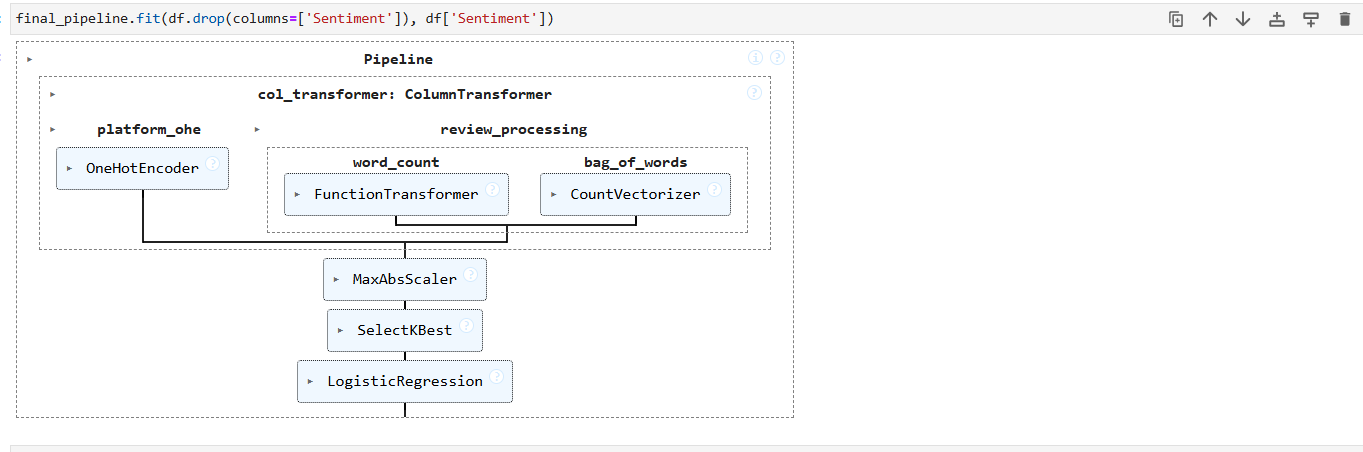
